This notebook provides recipes for loading and saving data from external sources.

In [ ]:
!pip install  torch
!pip install matplotlib
!pip install numpy
!pip install pandas

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

# Data Preparation

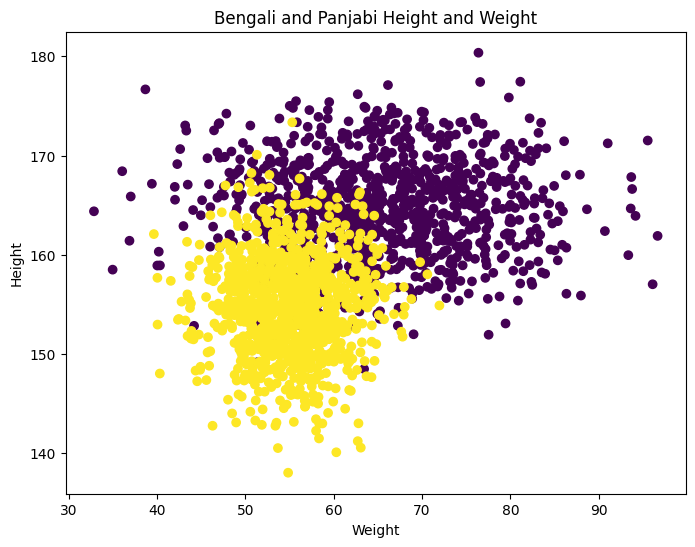

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Generate data
num_samples = 1000
panjabi_weights = torch.normal(65, 10, size=(num_samples,))
panjabi_heights = torch.normal(165, 5, size=(num_samples,))
bengali_weights = torch.normal(55, 5, size=(num_samples,))
bengali_heights = torch.normal(155, 5, size=(num_samples,))

# Create dataset
data = pd.DataFrame({
    'Weight': torch.cat((panjabi_weights, bengali_weights)),
    'Height': torch.cat((panjabi_heights, bengali_heights)),
    'Class': ['Panjabi'] * num_samples + ['Bengali'] * num_samples
})

# Map class labels to numerical values for color coding
class_mapping = {'Panjabi': 0, 'Bengali': 1}  # Map class labels to numbers
data['Class_Numeric'] = data['Class'].map(class_mapping)  # Create a new column with numerical class labels

# Plot the data
plt.figure(figsize=(8, 6))
# Use the numerical class labels for color coding
plt.scatter(data['Weight'], data['Height'], c=data['Class_Numeric'], cmap='viridis')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Bengali and Panjabi Height and Weight')
plt.show()

#Define Model

In [ ]:
# Define the neural network model
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = torch.nn.Linear(2, 8)
    self.linear2 = torch.nn.Linear(8, 8)
    self.linear3 = torch.nn.Linear(8, 2)

  def forward(self, x):
    x = torch.relu(self.linear1(x))
    x = torch.relu(self.linear2(x))
    x = self.linear3(x)
    return x

In [ ]:
# Define the neural network model
class NeuralNetwork_v2(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = torch.nn.Linear(2, 8)
    self.bn1 = torch.nn.BatchNorm1d(8)
    self.linear2 = torch.nn.Linear(8, 8)
    self.bn2 = torch.nn.BatchNorm1d(8)
    self.dropout = torch.nn.Dropout(p=0.2)
    self.linear3 = torch.nn.Linear(8, 2)

  def forward(self, x):
    x = torch.relu(self.bn1(self.linear1(x)))
    x = torch.relu(self.bn2(self.linear2(x)))
    #x = self.dropout(x)
    x = self.linear3(x)
    return x

#*Training* and Testing

Epoch: 0, Loss: 0.7286
Epoch: 10, Loss: 0.5126
Epoch: 20, Loss: 0.5706
Epoch: 30, Loss: 0.6920
Epoch: 40, Loss: 0.5917
Epoch: 50, Loss: 0.5667
Epoch: 60, Loss: 0.4980
Epoch: 70, Loss: 0.4503
Epoch: 80, Loss: 0.6018
Epoch: 90, Loss: 0.3412


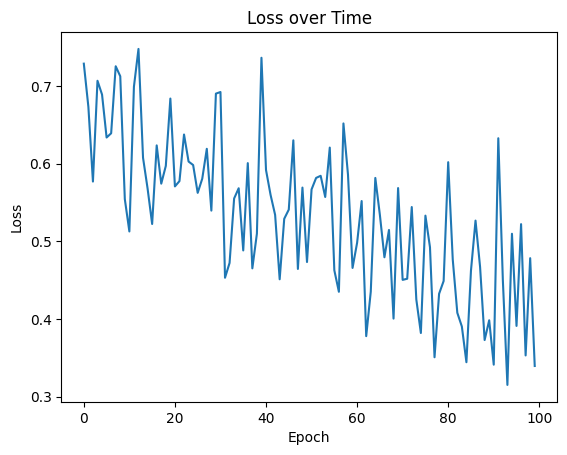

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data[['Weight', 'Height']], data['Class_Numeric'], test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Create a DataLoader for the training data
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=32, shuffle=True)

# Create an instance of the neural network
model = NeuralNetwork()

# Define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = []
# Train the model
for epoch in range(100):
  for X_batch, y_batch in train_loader:
    # Forward pass
    y_pred = model(X_batch)

    # Calculate the loss
    loss = loss_fn(y_pred, y_batch)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  # Print the loss every 10 epochs
  if epoch % 10 == 0:
    print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')

  losses.append(loss.item())

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.show()


## Test Results##

Test Loss: 0.4202, Accuracy: 0.79


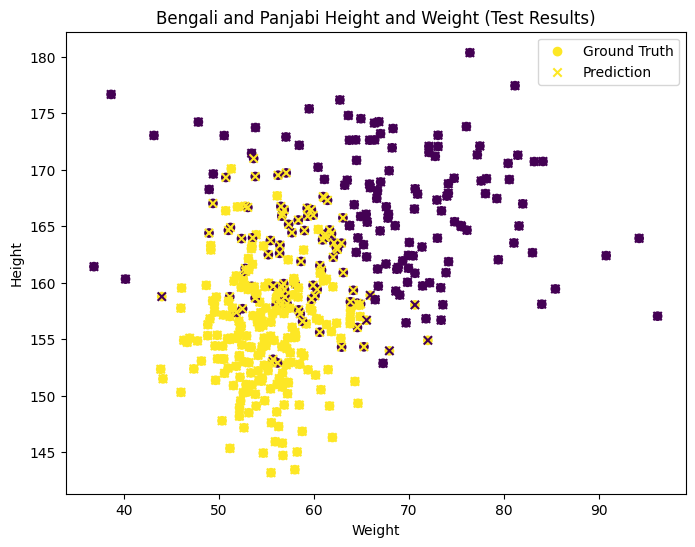

In [ ]:
# Evaluate the model on the test set
with torch.no_grad():
  y_pred = model(X_test)
  loss = loss_fn(y_pred, y_test)
  accuracy = (y_pred.argmax(dim=1) == y_test).sum().item() / len(y_test)
  print(f'Test Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}')


# Plot the test results
plt.figure(figsize=(8, 6))

# Use the numerical class labels for color coding
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', label='Ground Truth')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred.argmax(dim=1), cmap='viridis', marker='x', label='Prediction')

plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Bengali and Panjabi Height and Weight (Test Results)')
plt.legend()
plt.show()
